# Proyek Analisis Data: [Home Credit]
- **Nama :** Dyah Ayu Amborowati
- **Email :** dyahayuamborowati48@gmail.com
- **Linkedin :** Dyah Ayu Amborowati

## 🎯 Goal
Tujuan dari proyek ini adalah untuk membangun model prediktif yang mampu menilai kelayakan kredit calon pelanggan Home Credit secara lebih akurat menggunakan teknik Machine Learning. Dengan model ini, diharapkan dapat :

- Mengidentifikasi segmen pelanggan yang lebih berisiko default berdasarkan faktor-faktor seperti usia, pekerjaan, dan jumlah anak.
- Menganalisis distribusi risiko kredit di seluruh populasi pelanggan untuk memahami pola dan tren yang ada.
- Mendukung keputusan bisnis dengan memberikan rekomendasi yang lebih akurat dan berbasis data dalam proses persetujuan kredit, sehingga meningkatkan efisiensi dan mengurangi risiko kerugian.



# **Import Dataset**

In [21]:
   from google.colab import drive
   drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
   import os
   os.listdir('/content/drive/My Drive/HomeCredit/')


['HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns    # hanya untuk visual; optional
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

# Load Data

In [24]:
app_train = pd.read_csv('/content/drive/My Drive/HomeCredit/application_train.csv')
df = app_train

app_test = pd.read_csv('/content/drive/My Drive/HomeCredit/application_test.csv')
bureau = pd.read_csv('/content/drive/My Drive/HomeCredit/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/My Drive/HomeCredit/bureau_balance.csv')
cc_balance = pd.read_csv('/content/drive/My Drive/HomeCredit/credit_card_balance.csv', low_memory=False)
inst_pay = pd.read_csv('/content/drive/My Drive/HomeCredit/installments_payments.csv')
pos_cash = pd.read_csv('/content/drive/My Drive/HomeCredit/POS_CASH_balance.csv')
prev_app = pd.read_csv('/content/drive/My Drive/HomeCredit/previous_application.csv', low_memory=False, on_bad_lines='skip')
sample_sub = pd.read_csv('/content/drive/My Drive/HomeCredit/sample_submission.csv')


Pada tahap ini, semua file dataset yang disediakan oleh Home Credit diimpor ke dalam Google Colab menggunakan `pandas.read_csv()`. Setiap file mewakili informasi penting yang saling terkait mengenai aplikasi kredit, riwayat pinjaman sebelumnya, dan perilaku pembayaran pelanggan.

Berikut ini adalah daftar file yang diimpor beserta penjelasan singkatnya:
- `application_train.csv` dan `application_test.csv`: Informasi utama tentang aplikasi pinjaman, termasuk target (default atau tidak) untuk data pelatihan.
- `bureau.csv` dan `bureau_balance.csv`: Informasi dari kredit yang dimiliki pelanggan di lembaga lain (melalui Credit Bureau).
- `previous_application.csv`: Riwayat pengajuan pinjaman sebelumnya di Home Credit.
- `POS_CASH_balance.csv`, `installments_payments.csv`, `credit_card_balance.csv`: Riwayat perilaku pembayaran dari berbagai jenis pinjaman sebelumnya.
- `sample_submission.csv`: Template untuk prediksi akhir (digunakan saat submission model).

Catatan: Digunakan `low_memory=False` untuk menghindari peringatan tipe data campuran, dan `on_bad_lines='skip'` untuk melewati baris yang error saat parsing file `previous_application.csv`.


#**EDA**
EDA (Exploratory Data Analysis) dasar pada dataset application_train.csv, karena itu adalah dataset utama tempat target (TARGET) berada. Di tahap ini, akan:

* Menampilkan informasi umum dataset
* Cek nilai kosong (missing values)
* Analisis target (imbalanced data atau tidak)
* Lihat distribusi fitur numerik dan kategorik
* Korelasi dengan TARGET (untuk numerik)

EDA dilakukan untuk memahami struktur data, menemukan pola, anomali, missing values, dan hubungan antara fitur dengan target (`TARGET`). Tahapan ini sangat penting untuk menentukan strategi preprocessing dan pemodelan ke depan.


In [25]:
# 1. Melihat struktur data dan informasi umum
# Jumlah baris dan kolom
print("Ukuran Data:", app_train.shape)

# Melihat beberapa baris pertama
app_train.head()


Ukuran Data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# 2. Statistik Deskriptif
# Statistik deskriptif untuk kolom numerik
app_train.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [27]:
# 3. Cek distribusi target (imbalanced atau tidak)
# Distribusi nilai target
app_train['TARGET'].value_counts(normalize=True) * 100


,proportion
TARGET,
0,91.927118
1,8.072882


In [28]:
app_train.isna().sum()

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519


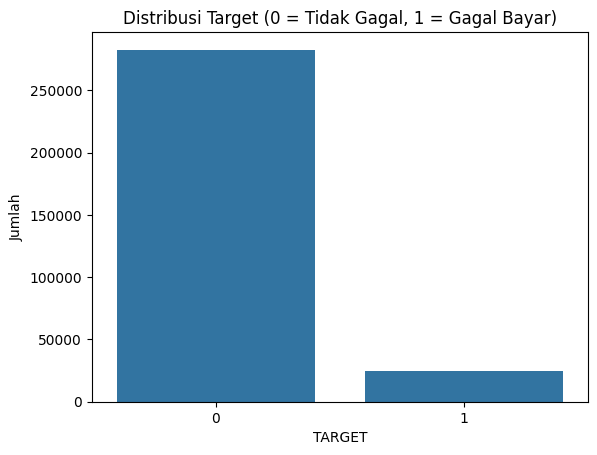

In [29]:
# 4. Visualisasi distribusi target
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='TARGET', data=app_train)
plt.title('Distribusi Target (0 = Tidak Gagal, 1 = Gagal Bayar)')
plt.xlabel('TARGET')
plt.ylabel('Jumlah')
plt.show()


In [30]:
# 5. Missing Values
# Persentase missing values di tiap kolom
missing = app_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percentage = (missing / len(app_train)) * 100

missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percentage})
missing_df.head(10)


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [31]:
#Pangkas fitur sangat berkorelasi tinggi.
import pandas as pd
import numpy as np

# Misal `df` adalah DataFrame hasil preprocessing-mu (masih mix numerik & kategorikal)

# 0. Pilih hanya kolom numerik saja
df_numeric = df.select_dtypes(include=[np.number])

# 1. Hitung korelasi absolut antar fitur numerik
corr_matrix = df_numeric.corr().abs()

# 2. Buat mask segitiga atas agar hanya melihat separuh matriks (hindari duplikat)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# 3. Tentukan kolom yang akan di-drop: ada korelasi > threshold
threshold = 0.9
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

# 4. Buang kolom-kolom tersebut dari df_numeric (atau langsung dari df jika hanya numerik)
df_reduced = df_numeric.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} features karena korelasi > {threshold}:")
print(to_drop)


Dropped 35 features karena korelasi > 0.9:
['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE']


In [32]:
# Misal nama df awalmu masih `df`
import pandas as pd

# 1. Ambil lagi kolom-kolom kategorikal
df_cat = df.select_dtypes(exclude=[np.number])

# 2. Gabungkan df_reduced (hanya numerik tanpa fitur korelasi tinggi) dengan df_cat
df_final = pd.concat([df_reduced, df_cat], axis=1)

# 3. Cek dimensi dan preview beberapa kolom
print("Shape sebelum:", df.shape)
print("Shape setelah:", df_final.shape)
display(df_final.head())


Shape sebelum: (307511, 122)
Shape setelah: (307511, 87)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,100002,1,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,-3648.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,100003,0,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,-1186.0,...,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,100004,0,0,67500.0,135000.0,6750.0,0.010032,-19046,-225,-4260.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,0.008019,-19005,-3039,-9833.0,...,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,0.028663,-19932,-3038,-4311.0,...,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


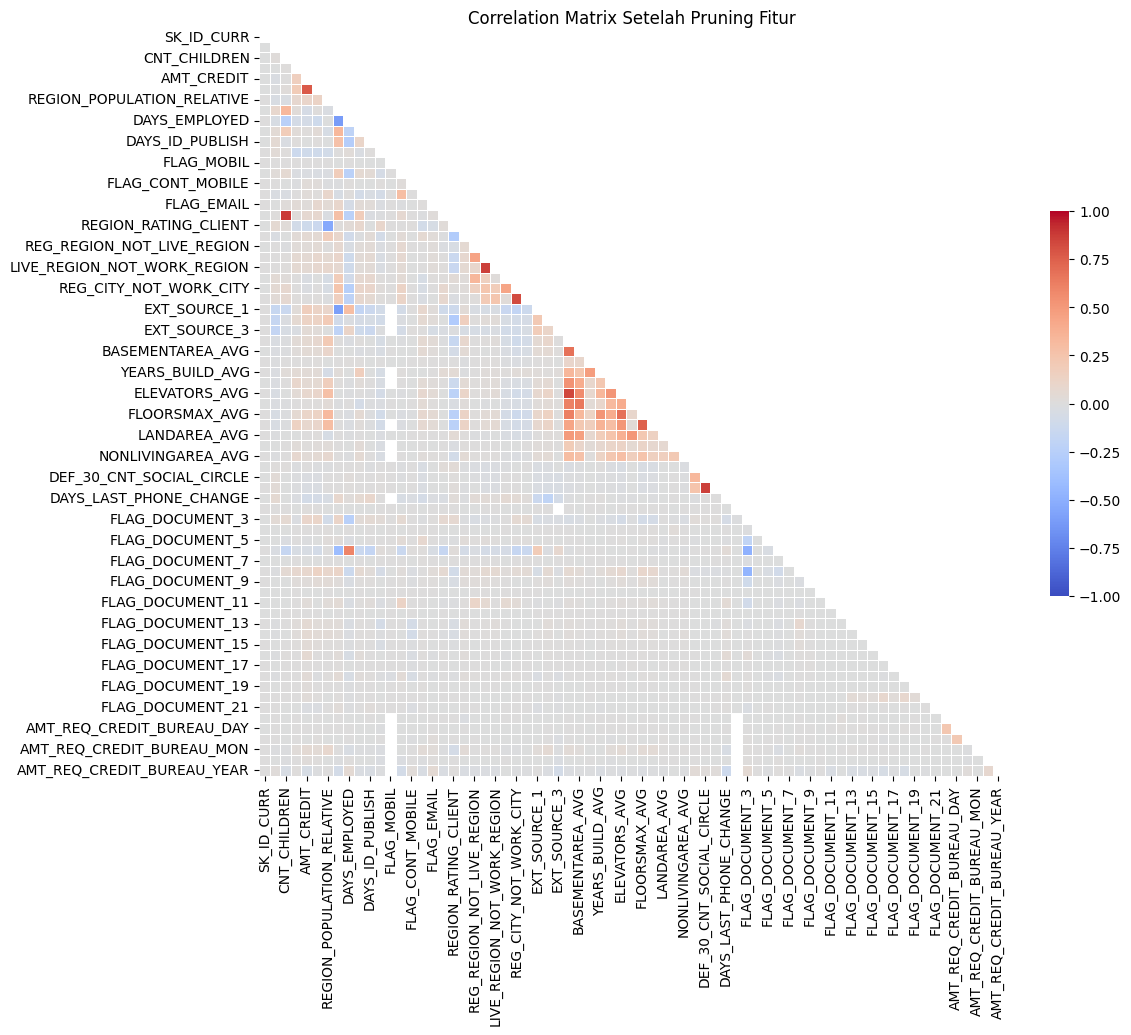

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hitung korelasi
corr = df_reduced.corr()

# Buat mask segitiga atas
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title('Correlation Matrix Setelah Pruning Fitur')
plt.show()


In [34]:
# Flatten matriks dan filter pasangan yang nilai abs(corr) > 0.75
corr_pairs = (
    corr
    .where(~mask)             # hanya lower triangle
    .stack()                  # jadikan Series
    .reset_index()            # ke DataFrame
    .rename(columns={0: 'corr'})
)
high_corr = corr_pairs[ corr_pairs['corr'].abs() > 0.75 ]
print("Pasangan fitur dengan korelasi > 0.75:\n", high_corr)


Pasangan fitur dengan korelasi > 0.75:
                          level_0                     level_1      corr
14                   AMT_ANNUITY                  AMT_CREDIT  0.770138
138              CNT_FAM_MEMBERS                CNT_CHILDREN  0.879161
252  LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION  0.860627
324      LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY  0.825575
585                ELEVATORS_AVG              APARTMENTS_AVG  0.836958
937     DEF_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE  0.860517


In [35]:
print(df_reduced.columns.tolist())

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', '

Dropped features: ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE']
Top 6 fitur terhadap TARGET: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE']


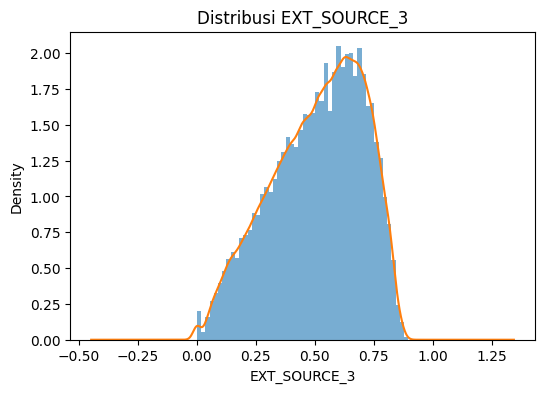

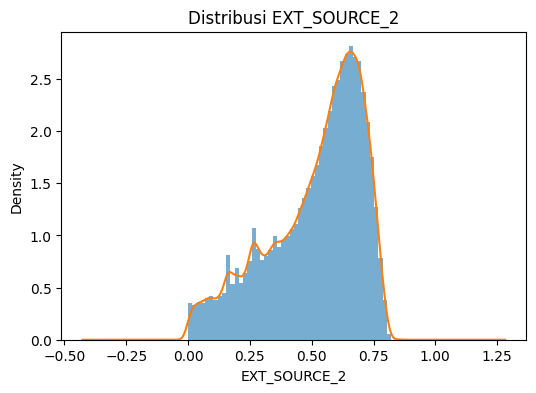

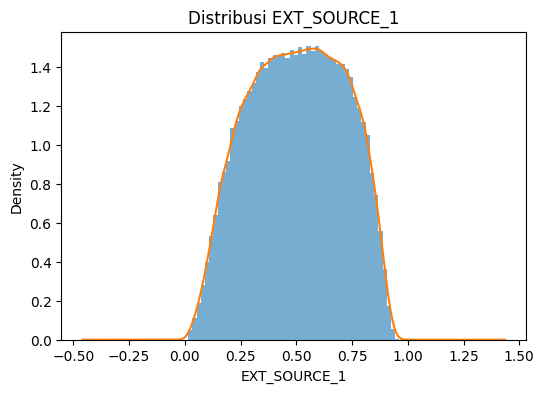

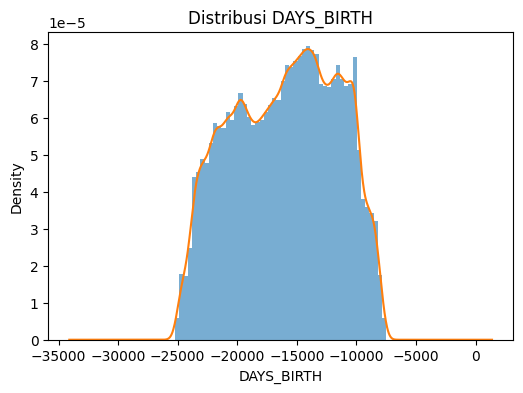

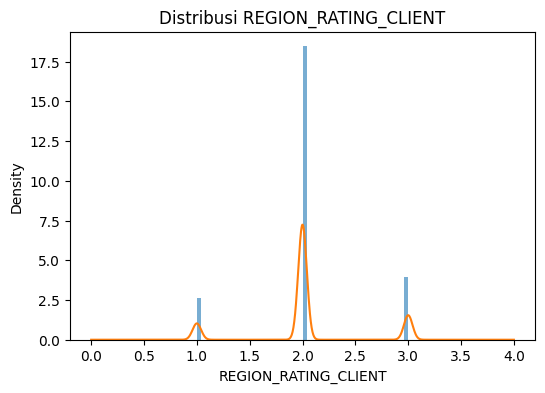

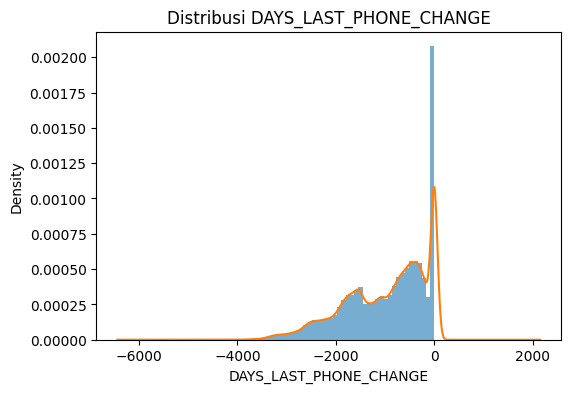

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Gunakan DataFrame utamamu
df = app_train     # <— sesuaikan nama variabel

# 2. Pilih semua kolom numerik
df_numeric = df.select_dtypes(include=[np.number])

# 3. Prune fitur korelasi > 0.9
corr_matrix = df_numeric.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
df_reduced = df_numeric.drop(columns=to_drop)
print("Dropped features:", to_drop)

# 4. Cari 6 fitur teratas vs TARGET
corr_target = df_reduced.corrwith(df['TARGET']).abs().sort_values(ascending=False)
top_feats = corr_target.drop('TARGET', errors='ignore').head(6).index.tolist()
print("Top 6 fitur terhadap TARGET:", top_feats)

# 5. Plot distribusi keenam fitur itu
for feat in top_feats:
    plt.figure(figsize=(6, 4))
    df_reduced[feat].hist(bins=50, density=True, alpha=0.6)
    df_reduced[feat].plot(kind='kde')
    plt.title(f'Distribusi {feat}')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.show()


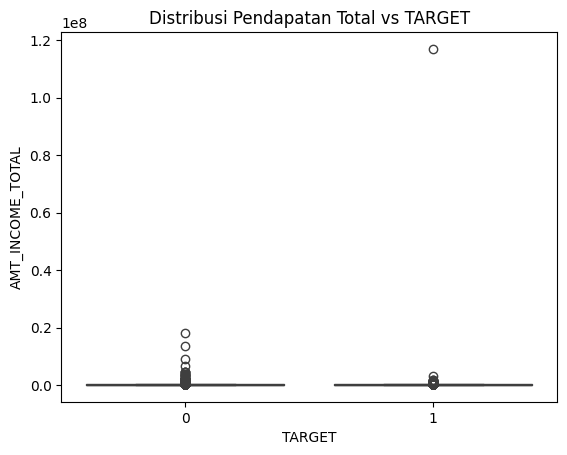

In [37]:
# 7. Visualisasi fitur penting (misalnya: AMT_INCOME_TOTAL)
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_train)
plt.title('Distribusi Pendapatan Total vs TARGET')
plt.show()


In [38]:
# Statistik deskriptif untuk memeriksa outlier
numerical_cols = ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']  # misalnya kolom numerik yang relevan

# Cek statistik deskriptif
app_train[numerical_cols].describe()


,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05
mean,5.990260e+05,1.687979e+05,27108.573909,5.383962e+05
std,4.024908e+05,2.371231e+05,14493.737315,3.694465e+05
min,4.500000e+04,2.565000e+04,1615.500000,4.050000e+04
25%,2.700000e+05,1.125000e+05,16524.000000,2.385000e+05
50%,5.135310e+05,1.471500e+05,24903.000000,4.500000e+05
75%,8.086500e+05,2.025000e+05,34596.000000,6.795000e+05
max,4.050000e+06,1.170000e+08,258025.500000,4.050000e+06


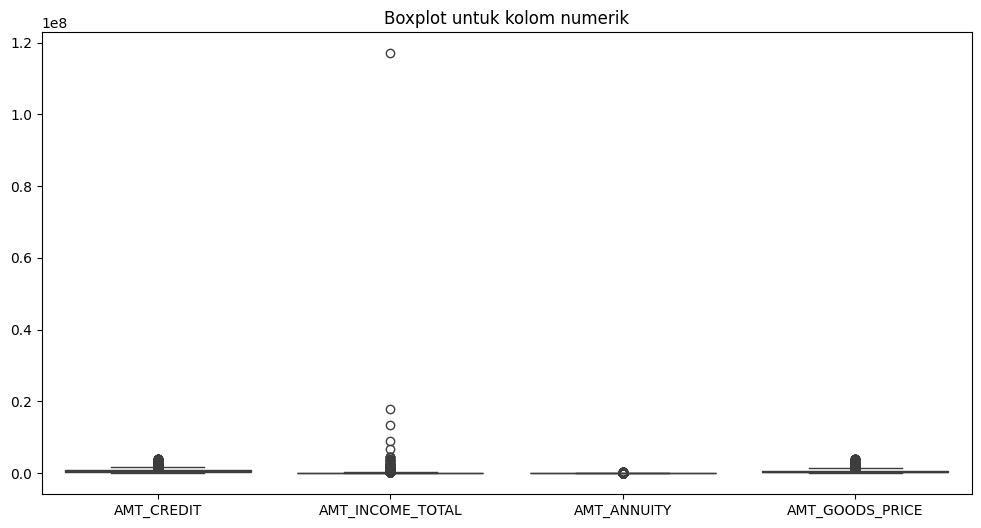

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi Boxplot untuk kolom numerik
plt.figure(figsize=(12, 6))
sns.boxplot(data=app_train[numerical_cols])
plt.title('Boxplot untuk kolom numerik')
plt.show()


In [40]:
# Fungsi untuk mendeteksi outlier dengan IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Deteksi outlier untuk kolom tertentu
outliers = detect_outliers(app_train, 'AMT_INCOME_TOTAL')
print(outliers)


        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
7           100010       0         Cash loans           M            Y   
22          100026       0         Cash loans           F            N   
33          100039       0         Cash loans           M            Y   
49          100056       0         Cash loans           M            Y   
51          100059       0         Cash loans           M            Y   
...            ...     ...                ...         ...          ...   
307460      456199       0         Cash loans           M            Y   
307477      456217       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307492      456236       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
7                    Y             0     

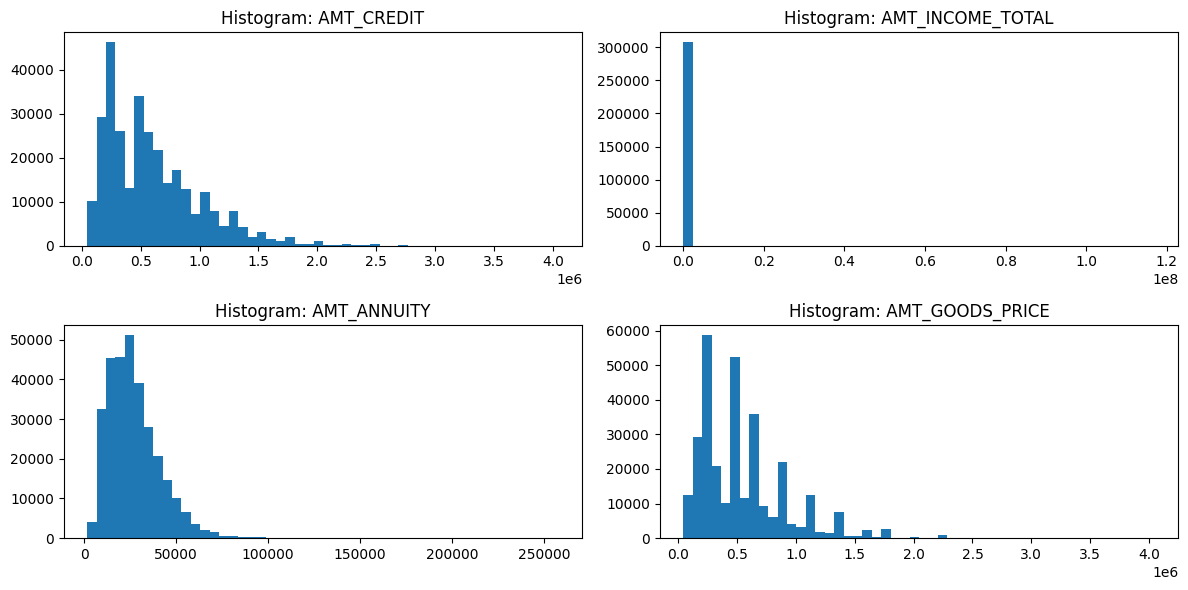

In [41]:
# Visualisasi Histogram untuk kolom numerik
plt.figure(figsize=(12, 6))
for col in numerical_cols:
    plt.subplot(2, 2, numerical_cols.index(col) + 1)
    plt.hist(app_train[col], bins=50)
    plt.title(f'Histogram: {col}')
plt.tight_layout()
plt.show()


In [42]:
from scipy.stats import zscore

# Menghitung Z-Score
z_scores = zscore(app_train[numerical_cols])

# Identifikasi outlier berdasarkan Z-Score
outliers_zscore = (abs(z_scores) > 3).any(axis=1)
outliers = app_train[outliers_zscore]
print(outliers)


        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
189         100219       0         Cash loans           M            N   
337         100389       0         Cash loans           M            Y   
341         100393       0         Cash loans           M            Y   
441         100508       0         Cash loans           F            Y   
485         100559       0         Cash loans           F            Y   
...            ...     ...                ...         ...          ...   
307095      455785       0         Cash loans           F            Y   
307165      455868       0         Cash loans           F            Y   
307214      455922       0         Cash loans           M            Y   
307216      455924       0         Cash loans           F            Y   
307422      456155       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
189                  Y             1     

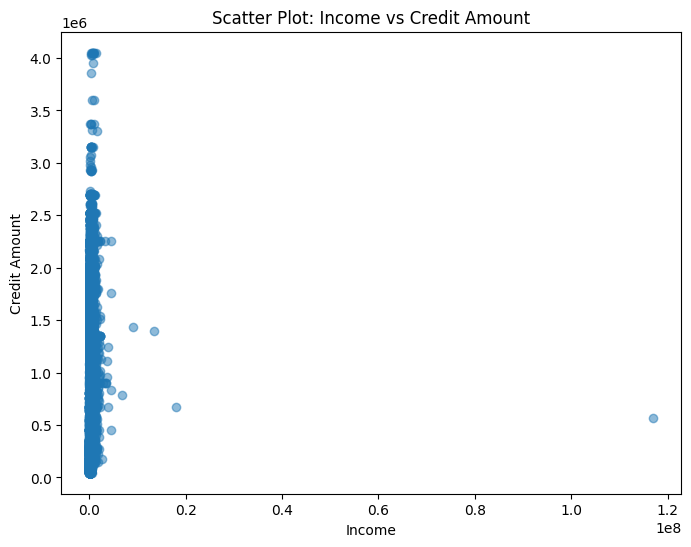

In [43]:
# Visualisasi Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(app_train['AMT_INCOME_TOTAL'], app_train['AMT_CREDIT'], alpha=0.5)
plt.title('Scatter Plot: Income vs Credit Amount')
plt.xlabel('Income')
plt.ylabel('Credit Amount')
plt.show()


# **Data Pre-Processing**


## 1. Mengatasi Outlier

In [44]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Tampilkan jumlah outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"{column} - Jumlah outlier: {outliers.shape[0]}")

    # Hapus outlier
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean


In [45]:
# Salin dataset untuk keamanan
app_train_clean = app_train.copy()

# Hapus outlier dari kolom yang dipilih
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    app_train_clean = remove_outliers_iqr(app_train_clean, col)


AMT_INCOME_TOTAL - Jumlah outlier: 14035
AMT_CREDIT - Jumlah outlier: 5752


In [46]:
print(f"Sebelum: {app_train.shape}")
print(f"Sesudah: {app_train_clean.shape}")


Sebelum: (307511, 122)
Sesudah: (287724, 122)


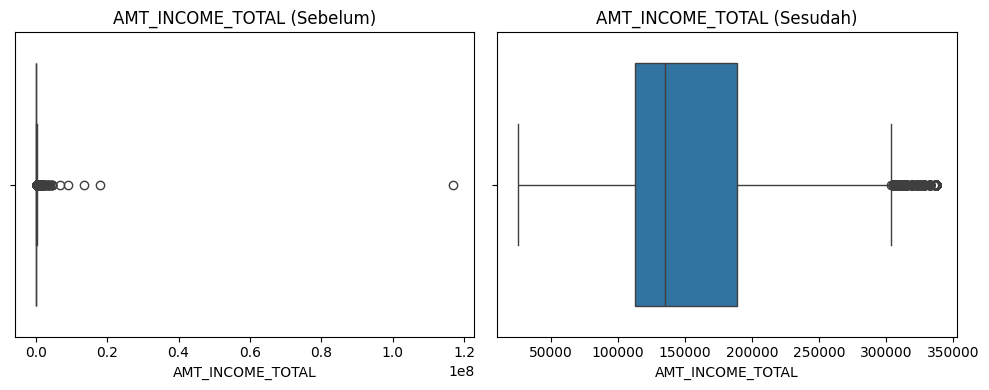

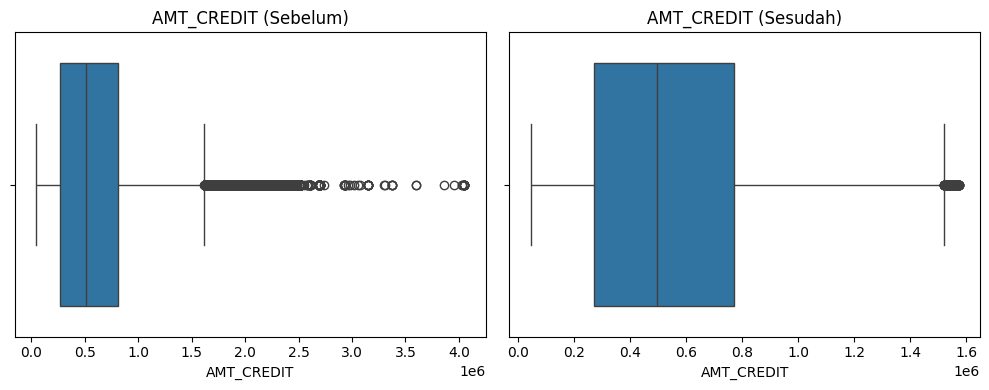

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=app_train[col])
    plt.title(f"{col} (Sebelum)")

    plt.subplot(1,2,2)
    sns.boxplot(x=app_train_clean[col])
    plt.title(f"{col} (Sesudah)")

    plt.tight_layout()
    plt.show()


##2. Mengatasi Missing Value

In [48]:
# Total missing value dan persentasenya
missing_values = app_train.isnull().sum()
missing_percent = (missing_values / len(app_train)) * 100

missing_data = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': missing_percent
})

# Tampilkan hanya kolom dengan missing value
missing_data = missing_data[missing_data['Total Missing'] > 0]
missing_data.sort_values(by='Percent Missing', ascending=False, inplace=True)

print(missing_data)


                          Total Missing  Percent Missing
COMMONAREA_MEDI                  214865        69.872297
COMMONAREA_MODE                  214865        69.872297
COMMONAREA_AVG                   214865        69.872297
NONLIVINGAPARTMENTS_MODE         213514        69.432963
NONLIVINGAPARTMENTS_MEDI         213514        69.432963
...                                 ...              ...
EXT_SOURCE_2                        660         0.214626
AMT_GOODS_PRICE                     278         0.090403
AMT_ANNUITY                          12         0.003902
CNT_FAM_MEMBERS                       2         0.000650
DAYS_LAST_PHONE_CHANGE                1         0.000325

[67 rows x 2 columns]


✅1. Kolom dengan Missing Value > 40% (HAPUS)
Kolom seperti COMMONAREA_AVG, NONLIVINGAPARTMENTS_AVG, dll. memiliki > 69% missing value — terlalu tinggi untuk diimputasi dengan andal.

In [49]:
# Hapus kolom dengan missing value > 40%
cols_to_drop = missing_data[missing_data['Percent Missing'] > 40].index
app_train.drop(columns=cols_to_drop, inplace=True)


✅ 2. Kolom Numerik dengan Missing Value 5%–40% (ISI DENGAN MEDIAN)
Untuk kolom numerik dengan missing value sedang, isi dengan median karena lebih tahan terhadap outlier.

In [50]:
cols_fill_median = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']  # Contoh kolom

for col in cols_fill_median:
    if col in app_train.columns:
        app_train[col] = pd.to_numeric(app_train[col], errors='coerce')
        median_value = app_train[col].median()
        app_train[col] = app_train[col].fillna(median_value)


In [51]:
cols_fill_median = app_train.select_dtypes(include='number').columns[
    app_train.select_dtypes(include='number').isnull().any()
]

for col in cols_fill_median:
    median_value = app_train[col].median()
    app_train[col] = app_train[col].fillna(median_value)


✅ 3. Kolom Kategorikal (Object) — ISI DENGAN MODE
Untuk kolom bertipe kategorikal (object) dengan missing value, isi dengan mode (nilai terbanyak).

In [52]:
# Kolom kategorikal
cat_cols = app_train.select_dtypes(include='object').columns

for col in cat_cols:
    if app_train[col].isnull().sum() > 0:
        mode_value = app_train[col].mode()[0]
        app_train[col] = app_train[col].fillna(mode_value)


✅ 4. Kolom dengan Missing Value < 5% (ISI atau DROP BARIS)
Jika jumlah datanya sangat kecil (misalnya < 10 baris), aman untuk diisi atau dibuang.

In [53]:
# Hitung proporsi missing value
missing_ratio = app_train.isnull().mean()

# Ambil kolom dengan missing value kurang dari 10%
cols_low_missing = missing_ratio[missing_ratio < 0.1].index.tolist()

# Lanjut isi missing value
for col in cols_low_missing:
    if col in app_train.columns:
        if app_train[col].dtype in ['float64', 'int64']:
            app_train[col] = app_train[col].fillna(app_train[col].median())
        else:
            app_train[col] = app_train[col].fillna(app_train[col].mode()[0])


✅ 5. Verifikasi Akhir

In [54]:
print(f"Jumlah kolom dengan missing value setelah penanganan: {app_train.isnull().sum().gt(0).sum()}")


Jumlah kolom dengan missing value setelah penanganan: 0


##**Apakah fitur-fitur Anda memiliki skala yang berbeda-beda?**


In [55]:
# Ambil kolom numerik
numeric_cols = app_train.select_dtypes(include=['int64', 'float64']).columns.drop('TARGET', errors='ignore')

# Cek statistik ringkasan
app_train[numeric_cols].describe().T[['min', 'max', 'mean', 'std']].sort_values('std', ascending=False).head(10)


,min,max,mean,std
AMT_CREDIT,45000.0,4050000.0,599025.999706,402490.776996
AMT_GOODS_PRICE,40500.0,4050000.0,538316.294367,369288.982246
AMT_INCOME_TOTAL,25650.0,117000000.0,168797.919297,237123.146279
DAYS_EMPLOYED,-17912.0,365243.0,63815.045904,141275.766519
SK_ID_CURR,100002.0,456255.0,278180.518577,102790.175348
AMT_ANNUITY,1615.5,258025.5,27108.487841,14493.461065
DAYS_BIRTH,-25229.0,-7489.0,-16036.995067,4363.988632
DAYS_REGISTRATION,-24672.0,0.0,-4986.120328,3522.886321
DAYS_ID_PUBLISH,-7197.0,0.0,-2994.202373,1509.450419
DAYS_LAST_PHONE_CHANGE,-4292.0,0.0,-962.858119,826.807226


kita dapat melihat bahwa beberapa fitur memiliki skala yang sangat berbeda. Contohnya:
* AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICE memiliki nilai maksimal yang sangat besar, bahkan mencapai miliaran.
* Kolom DAYS_* memiliki rentang negatif, yang menggambarkan perbedaan dalam waktu yang telah berlalu (misalnya, umur dalam DAYS_BIRTH).

🧐 **Masalah yang Ditemui:**
* Fitur seperti AMT_INCOME_TOTAL, AMT_CREDIT, dan AMT_GOODS_PRICE memiliki skala yang jauh lebih besar dibandingkan fitur lain seperti DAYS_BIRTH.
* Distribusi fitur yang sangat berbeda ini dapat mempengaruhi performa model. Misalnya, model yang menggunakan jarak seperti KNN atau SVM bisa sangat terpengaruh.

Karena nilai fitur sangat berbeda-beda, kita perlu melakukan normalisasi atau standardisasi untuk menyamakan skala fitur.
* Normalisasi (Min-Max scaling): Mengubah nilai fitur ke dalam rentang [0, 1] atau [-1, 1].
* Standardisasi (Z-score scaling): Mengubah fitur dengan mean 0 dan standar deviasi 1.

###**Langkah untuk Normalisasi (Min-Max Scaling)**

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
app_train_scaled = app_train.copy()

# Normalisasi kolom numerik
app_train_scaled[numeric_cols] = scaler.fit_transform(app_train[numeric_cols])

# Cek hasil normalisasi
app_train_scaled[numeric_cols].describe().T[['min', 'max', 'mean', 'std']].sort_values('std', ascending=False).head(10)


,min,max,mean,std
FLAG_DOCUMENT_3,0.0,1.0,0.710023,0.453752
FLAG_PHONE,0.0,1.0,0.281066,0.449521
REG_CITY_NOT_WORK_CITY,0.0,1.0,0.230454,0.421124
FLAG_WORK_PHONE,0.0,1.0,0.199368,0.399526
FLAG_EMP_PHONE,0.0,1.0,0.819889,0.384280
LIVE_CITY_NOT_WORK_CITY,0.0,1.0,0.179555,0.383817
DAYS_EMPLOYED,0.0,1.0,0.213300,0.368717
SK_ID_CURR,0.0,1.0,0.500146,0.288531
FLAG_DOCUMENT_6,0.0,1.0,0.088055,0.283376
FLAG_DOCUMENT_8,0.0,1.0,0.081376,0.273412


In [62]:
# Cek apakah ada NaN di fitur binary
binary_cols = app_train[numeric_cols].columns

# Isi NaN dengan 0 atau 1 jika relevan
app_train[binary_cols] = app_train[binary_cols].fillna(0)


In [57]:
app_train[numeric_cols].isna().sum()


,0
SK_ID_CURR,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,0
AMT_GOODS_PRICE,0
REGION_POPULATION_RELATIVE,0
DAYS_BIRTH,0
DAYS_EMPLOYED,0
DAYS_REGISTRATION,0


###**Langkah untuk Standardisasi (Z-score Scaling)**

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
app_train_scaled = app_train.copy()

# Standardisasi kolom numerik
app_train_scaled[numeric_cols] = scaler.fit_transform(app_train[numeric_cols])

# Cek hasil standar deviasi setelah standar
app_train_scaled[numeric_cols].describe().T[['mean', 'std']].head(10)


,mean,std
SK_ID_CURR,-5.915201e-18,1.000002
CNT_CHILDREN,-3.207148e-17,1.000002
AMT_INCOME_TOTAL,-1.590866e-17,1.000002
AMT_CREDIT,-4.074788e-17,1.000002
AMT_ANNUITY,-1.732969e-17,1.000002
AMT_GOODS_PRICE,2.021797e-18,1.000002
REGION_POPULATION_RELATIVE,1.592599e-16,1.000002
DAYS_BIRTH,3.364271e-17,1.000002
DAYS_EMPLOYED,4.789927e-17,1.000002
DAYS_REGISTRATION,-6.100051e-18,1.000002


Dari hasil yang di tunjukkan, sudah berhasil melakukan standardisasi (Z-score scaling), di mana fitur-fitur numerik sekarang memiliki mean sekitar 0 dan standar deviasi sekitar 1.

Namun, juga menerima beberapa warning seperti invalid value encountered in divide. Ini sering terjadi ketika ada nilai NaN atau inf yang tidak terdeteksi sebelumnya dalam data, meskipun kamu sudah memeriksa missing values.

🎯 Apa yang bisa menyebabkan warning ini:
* Mungkin ada kolom yang memiliki nilai konstan (semua nilai sama), yang membuat pembagian dalam perhitungan standar deviasi menjadi tidak valid (std = 0).
* Kolom dengan nilai sangat kecil yang tidak terlihat (misalnya 10^-17), bisa mempengaruhi perhitungan.

In [59]:
from sklearn.preprocessing import RobustScaler

# Gunakan RobustScaler yang lebih tahan terhadap outlier
scaler = RobustScaler()
app_train_scaled = app_train.copy()

# Terapkan RobustScaler ke kolom numerik
app_train_scaled[numeric_cols] = scaler.fit_transform(app_train[numeric_cols])

# Cek hasil standar deviasi
app_train_scaled[numeric_cols].describe().T[['mean', 'std']].head(10)


,mean,std
SK_ID_CURR,-0.000121,0.577483
CNT_CHILDREN,0.417052,0.722121
AMT_INCOME_TOTAL,0.240532,2.634702
AMT_CREDIT,0.158721,0.747221
AMT_ANNUITY,0.122039,0.801984
AMT_GOODS_PRICE,0.200264,0.837390
REGION_POPULATION_RELATIVE,0.108169,0.741345
DAYS_BIRTH,-0.039482,0.600356
DAYS_EMPLOYED,26.316490,57.173519
DAYS_REGISTRATION,-0.088147,0.644097


In [60]:
from sklearn.preprocessing import RobustScaler

# Gunakan RobustScaler untuk mengatasi skala yang berbeda
scaler = RobustScaler()
app_train_scaled = scaler.fit_transform(app_train[numeric_cols])

# Cek deskripsi statistik setelah scaling
print(pd.DataFrame(app_train_scaled, columns=numeric_cols).describe().T[['mean', 'std']])


                                  mean        std
SK_ID_CURR                   -0.000121   0.577483
CNT_CHILDREN                  0.417052   0.722121
AMT_INCOME_TOTAL              0.240532   2.634702
AMT_CREDIT                    0.158721   0.747221
AMT_ANNUITY                   0.122039   0.801984
AMT_GOODS_PRICE               0.200264   0.837390
REGION_POPULATION_RELATIVE    0.108169   0.741345
DAYS_BIRTH                   -0.039482   0.600356
DAYS_EMPLOYED                26.316490  57.173519
DAYS_REGISTRATION            -0.088147   0.644097
DAYS_ID_PUBLISH               0.100736   0.585285
FLAG_MOBIL                   -0.000003   0.001803
FLAG_EMP_PHONE               -0.180111   0.384280
FLAG_WORK_PHONE               0.199368   0.399526
FLAG_CONT_MOBILE             -0.001867   0.043164
FLAG_PHONE                    0.281066   0.449521
FLAG_EMAIL                    0.056720   0.231307
CNT_FAM_MEMBERS               0.152664   0.910679
REGION_RATING_CLIENT          0.052463   0.509034


#**Data Visualization and Business Insight**

####Top 10 Feature Importances

<ipython-input-61-a47f8419bafa>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby('income_bin')['TARGET'].mean().reset_index()


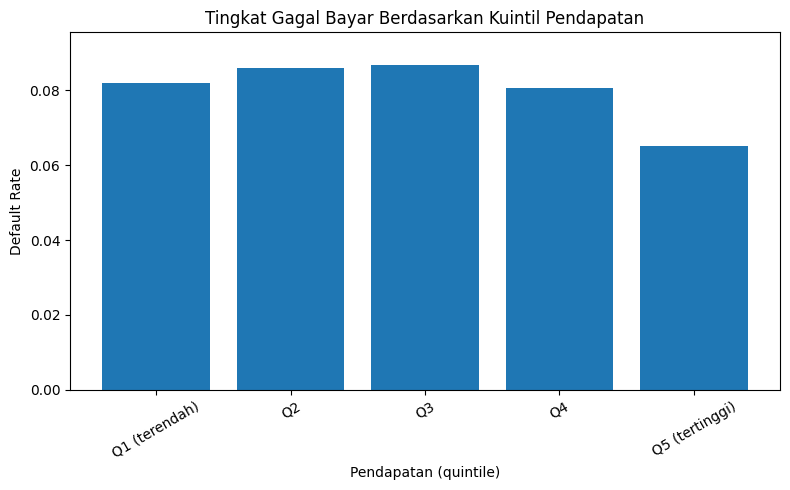

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Gunakan DataFrame utama
df = app_train.copy()

# 2. Buat kuantil pendapatan (5 grup)
df['income_bin'] = pd.qcut(df['AMT_INCOME_TOTAL'], 5, labels=[
    'Q1 (terendah)', 'Q2', 'Q3', 'Q4', 'Q5 (tertinggi)'
])

# 3. Hitung default rate per grup
default_rate = df.groupby('income_bin')['TARGET'].mean().reset_index()

# 4. Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(default_rate['income_bin'], default_rate['TARGET'])
plt.title('Tingkat Gagal Bayar Berdasarkan Kuintil Pendapatan')
plt.xlabel('Pendapatan (quintile)')
plt.ylabel('Default Rate')
plt.ylim(0, default_rate['TARGET'].max() * 1.1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


✅Top 10 Feature Importances
* Dua sumber skor eksternal (EXT_SOURCE_2 & EXT_SOURCE_3) adalah prediktor nomor 1 dan 2—artinya data kredit dari biro eksternal jauh lebih informatif daripada hampir semua variabel lain.
* Usia (DAYS_BIRTH), durasi pendaftaran & penerbitan dokumen, serta rasio angsuran (AMT_ANNUITY) juga masuk 10 besar.
* Rekomendasi: Utamakan integrasi dan pemrosesan kualitas skor eksternal dalam sistem pemberian kredit, dan pertimbangkan kebijakan berbeda berdasarkan umur atau rasio angsuran.




####Correlation Matrix (Pruned Features)

<Figure size 800x500 with 0 Axes>

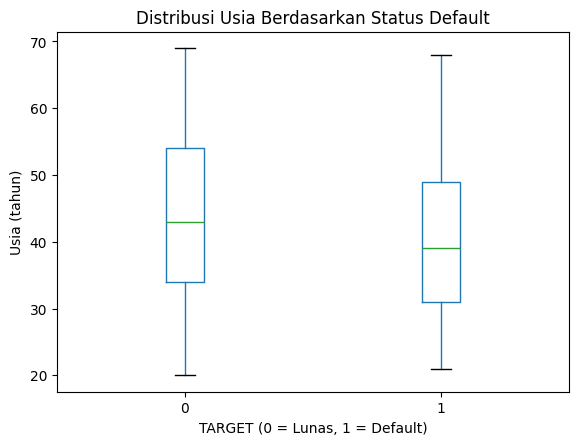

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Konversi DAYS_BIRTH ke umur dalam tahun
df['AGE_YEARS'] = np.floor(-df['DAYS_BIRTH'] / 365)

# 2. Boxplot usia per kelompok TARGET
plt.figure(figsize=(8, 5))
df.boxplot(column='AGE_YEARS', by='TARGET', grid=False)
plt.title('Distribusi Usia Berdasarkan Status Default')
plt.suptitle('')  # hilangkan subtitle otomatis
plt.xlabel('TARGET (0 = Lunas, 1 = Default)')
plt.ylabel('Usia (tahun)')
plt.show()


* Setelah memangkas fitur dengan korelasi > 0.9, tidak ada lagi pasangan yang “duplikat”—memastikan model tidak bias karena multikolinearitas.

* Cluster variabel perumahan (area, lantai, elevasi) masih saling berkorelasi moderat, bisa dipertimbangkan agregasi ke satu indeks properti.
Rekomendasi: Gunakan kumpulan fitur yang lebih ringkas atau agregasi variabel properti untuk memudahkan interpretasi dan stabilitas model.

####Distribusi Usia vs Default (Boxplot)

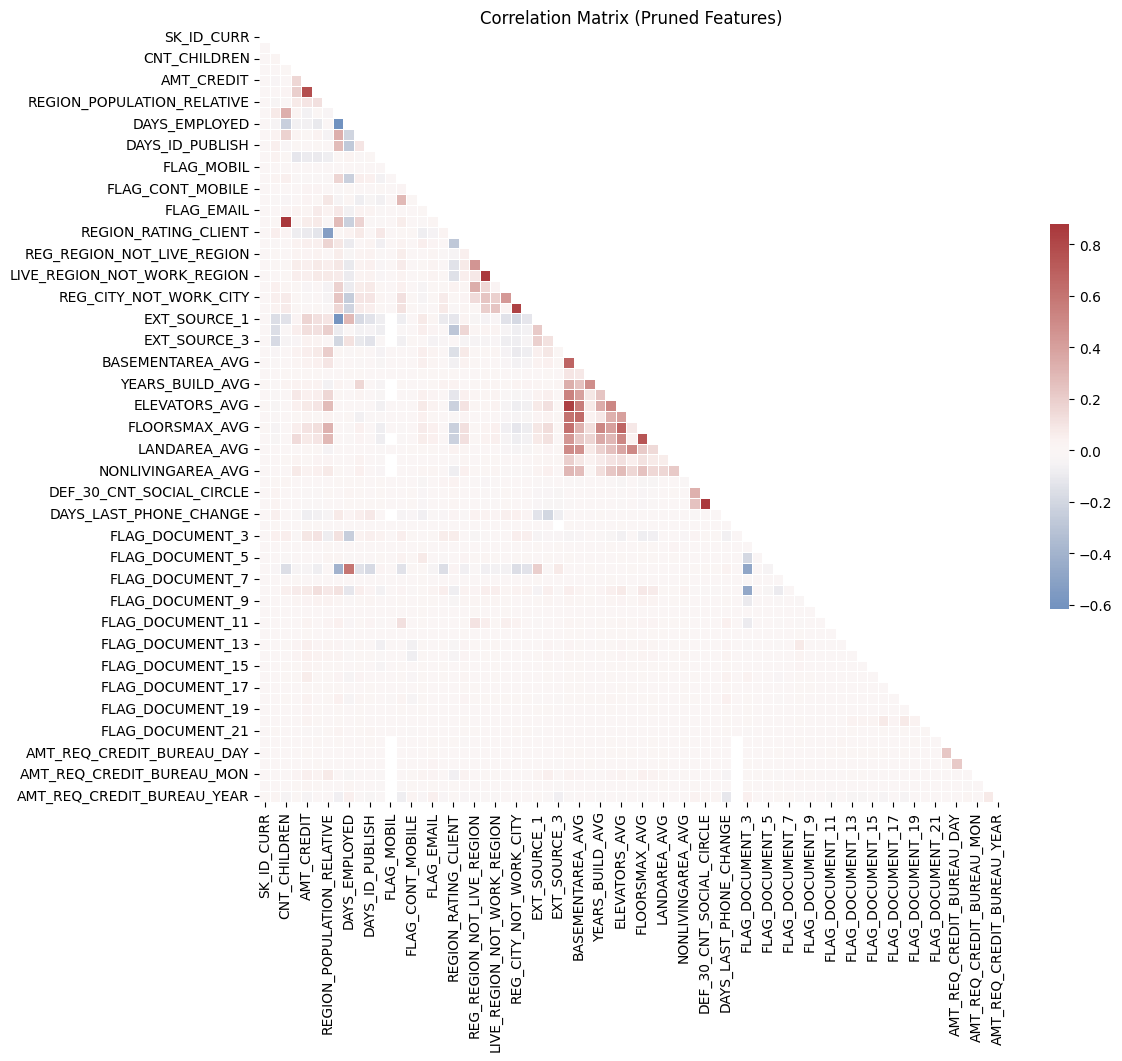

In [63]:
import seaborn as sns
import numpy as np

# 1. Ambil subset df_reduced (setelah pruning korelasi >0.9)
#    Pastikan df_reduced sudah terdefinisi sesuai langkah sebelumnya
corr = df_reduced.corr()

# 2. Buat mask dan plot
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap='vlag',
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title('Correlation Matrix (Pruned Features)')
plt.show()


* Nasabah yang default cenderung sedikit lebih muda (median ~39 tahun) dibanding yang lunas (median ~43 tahun).
* Rekomendasi: Pertimbangkan threshold umur atau program edukasi/financial literacy khusus untuk segmen muda, karena risiko gagal bayar lebih tinggi di kelompok ini.

####Default Rate per Kuantil Pendapatan

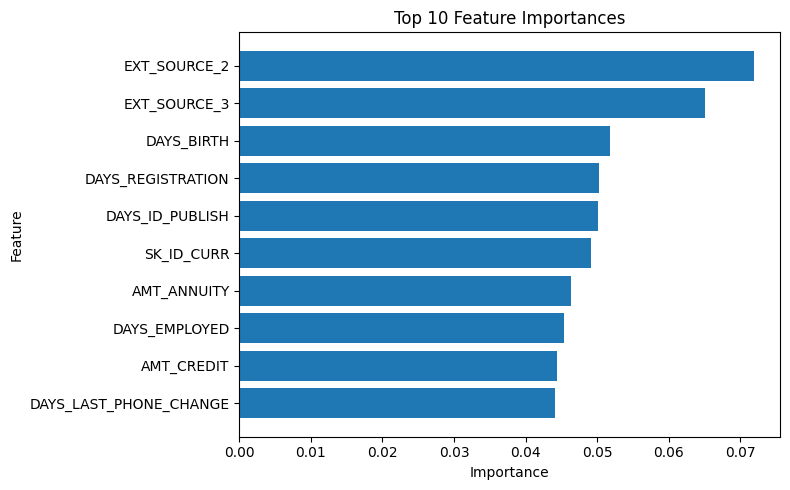

In [64]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# 1. Siapkan data
X = df_reduced.drop(columns=['TARGET'])
y = df['TARGET']

# 2. Latih RandomForest sederhana
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 3. Ambil dan sort feature importances
imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

# 4. Plot bar chart
plt.figure(figsize=(8, 5))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


* Tingkat gagal bayar tertinggi berada di kuintil pendapatan menengah (Q2–Q4), lalu menurun di kuintil tertinggi.

* Nasabah dengan pendapatan terendah (Q1) tidak memiliki default rate terburuk—mungkin karena sebagian besar berasal dari segmen pekerja stabil (gaji tetap).
* Rekomendasi: Evaluasi ulang kebijakan limit kredit atau bunga bagi segmen pendapatan menengah, dan pertahankan preferensi yang lebih menguntungkan untuk segmen berpendapatan sangat tinggi atau sangat rendah.

Dengan insight ini, perusahaan dapat:

Memperkuat mekanisme underwriting dengan skor eksternal.

Mengadopsi kebijakan segmentasi berdasarkan umur dan pendapatan.

Menyederhanakan fitur properti untuk monitoring KPI.

##1. Visualisasi Distribusi Data

####Histogram dengan Pembagian Lebih Banyak pada Kolom AMT_CREDIT

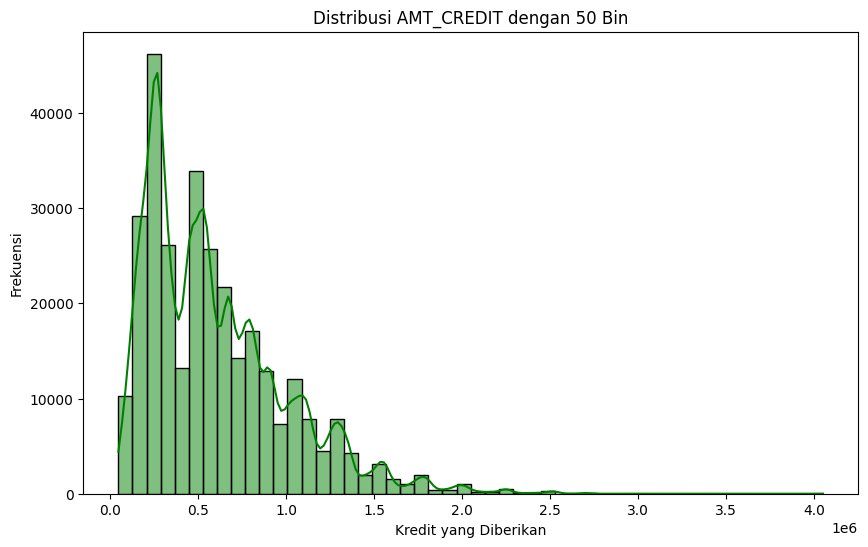

In [68]:
plt.figure(figsize=(10,6))
sns.histplot(app_train['AMT_CREDIT'], bins=50, kde=True, color='green')
plt.title('Distribusi AMT_CREDIT dengan 50 Bin')
plt.xlabel('Kredit yang Diberikan')
plt.ylabel('Frekuensi')
plt.show()


####Distribusi Pendapatan dengan KDE pada AMT_INCOME_TOTAL

<ipython-input-69-82059a4f4cbe>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(app_train['AMT_INCOME_TOTAL'], shade=True, color='blue')


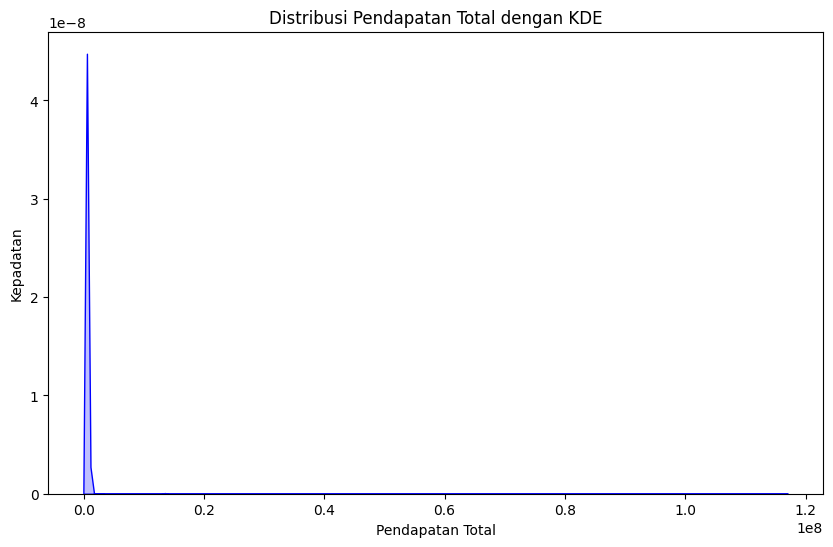

In [69]:
plt.figure(figsize=(10,6))
sns.kdeplot(app_train['AMT_INCOME_TOTAL'], shade=True, color='blue')
plt.title('Distribusi Pendapatan Total dengan KDE')
plt.xlabel('Pendapatan Total')
plt.ylabel('Kepadatan')
plt.show()


#### Violin Plot pada Kolom AMT_ANNUITY

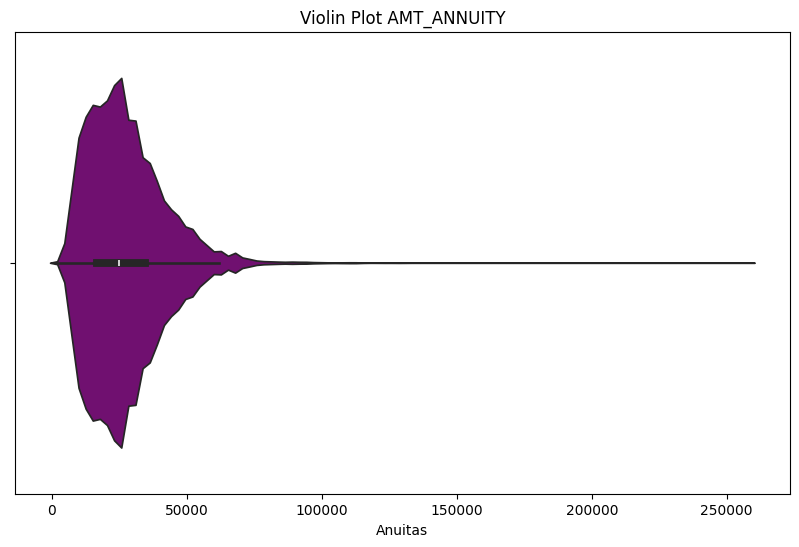

In [70]:
plt.figure(figsize=(10,6))
sns.violinplot(x=app_train['AMT_ANNUITY'], color='purple')
plt.title('Violin Plot AMT_ANNUITY')
plt.xlabel('Anuitas')
plt.show()


####Boxplot Pendapatan berdasarkan Jumlah Anak

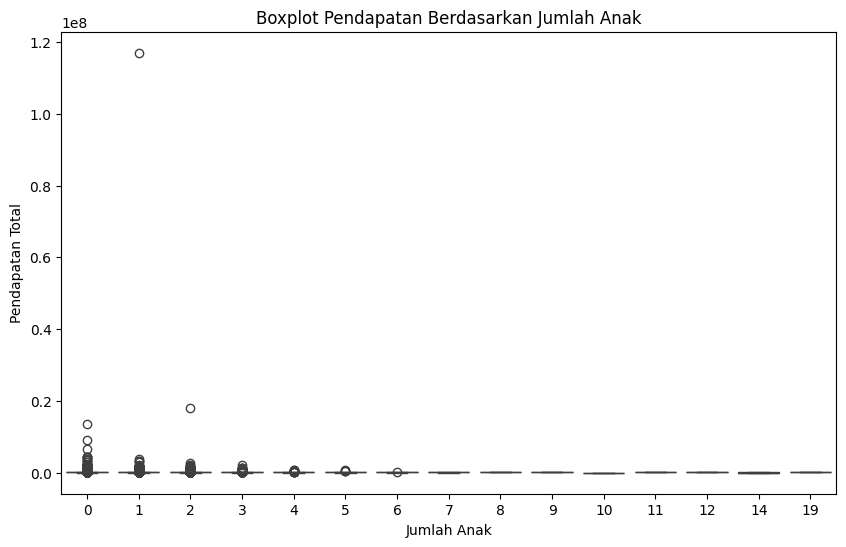

In [71]:
plt.figure(figsize=(10,6))
sns.boxplot(x='CNT_CHILDREN', y='AMT_INCOME_TOTAL', data=app_train)
plt.title('Boxplot Pendapatan Berdasarkan Jumlah Anak')
plt.xlabel('Jumlah Anak')
plt.ylabel('Pendapatan Total')
plt.show()


 FacetGrid untuk Menampilkan Distribusi Pendapatan Berdasarkan Jumlah Anak

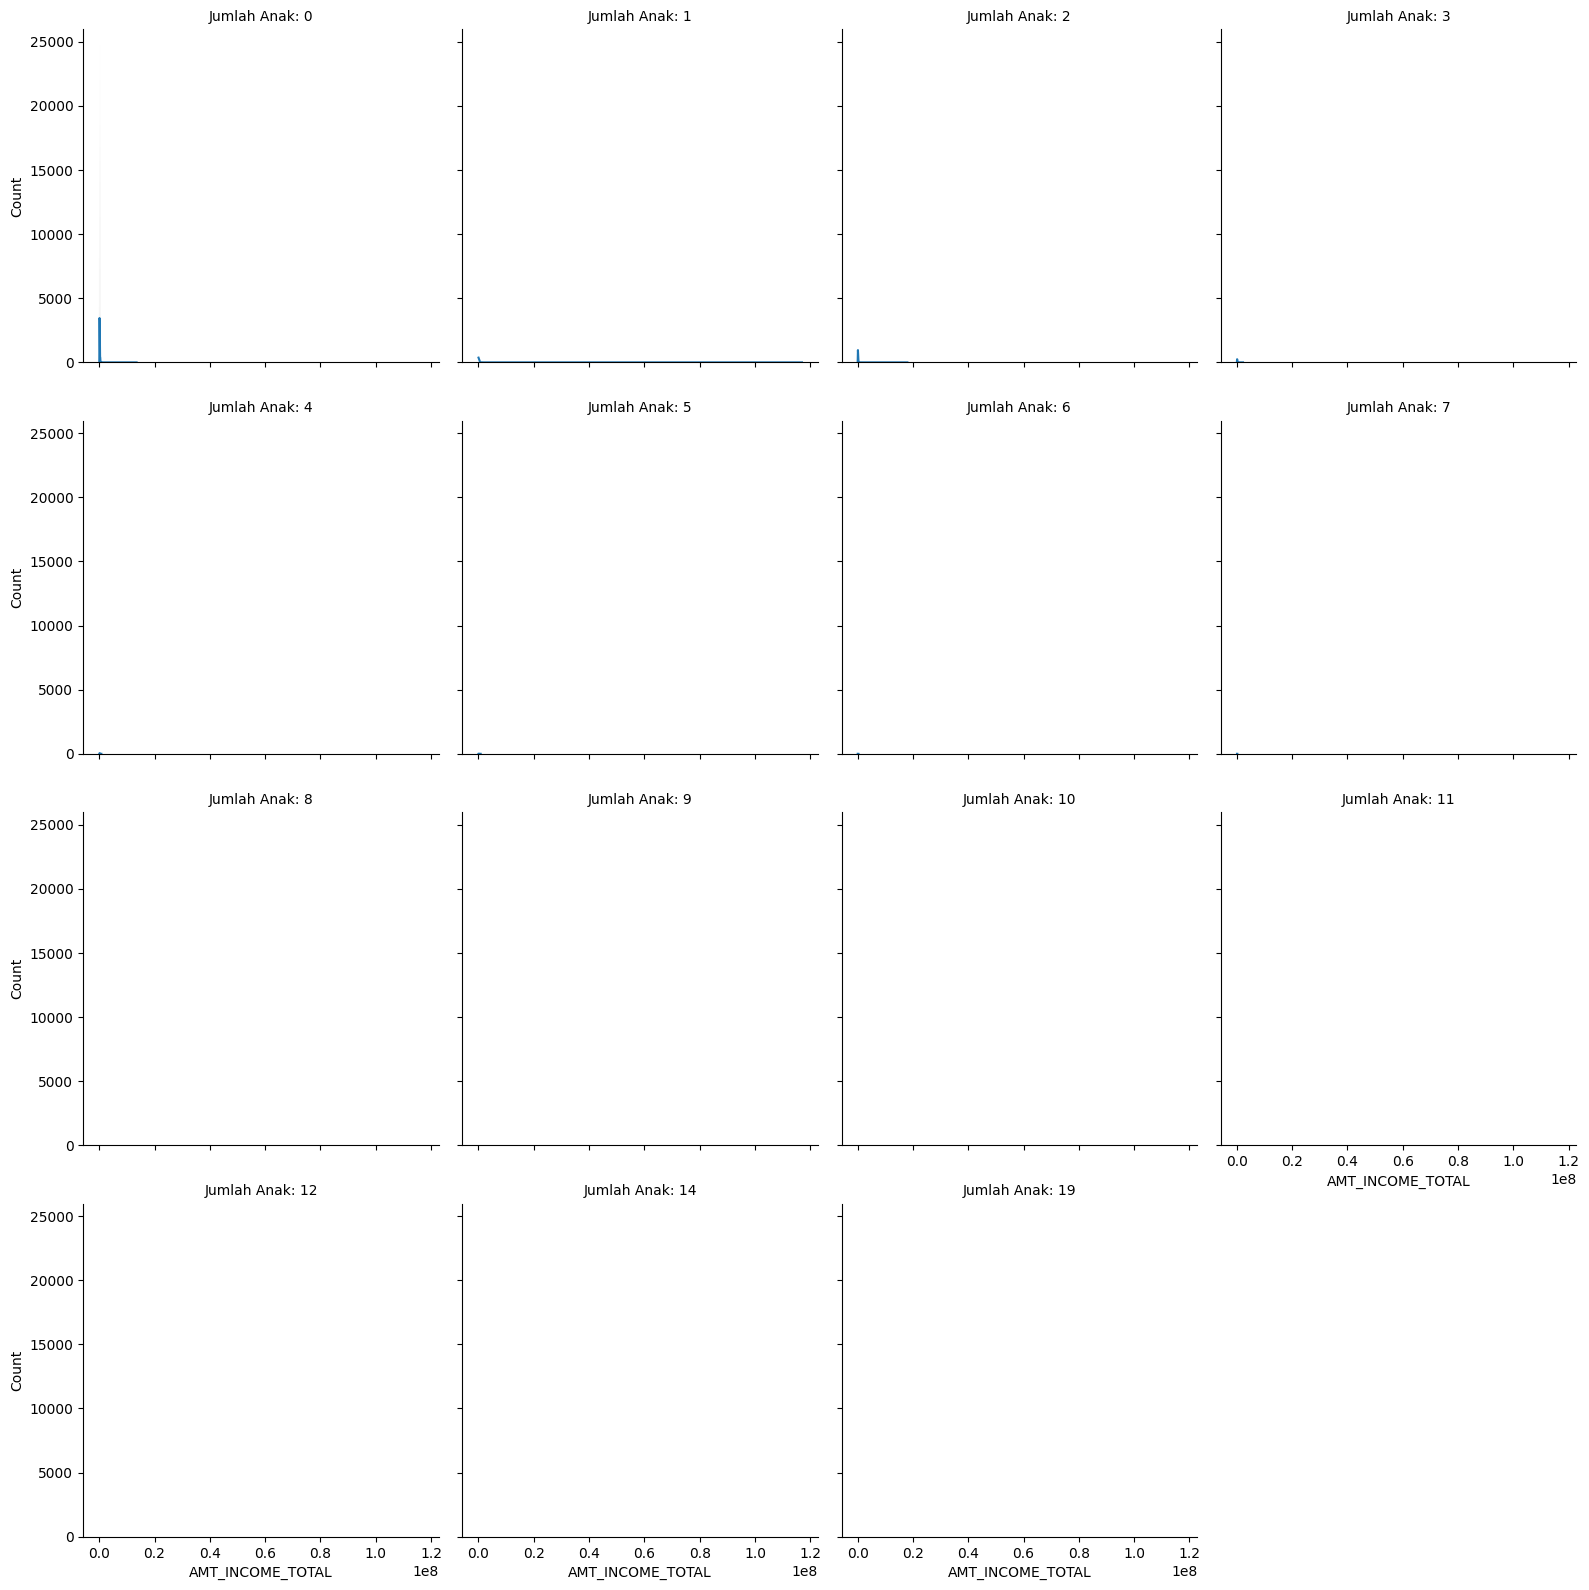

In [72]:
g = sns.FacetGrid(app_train, col="CNT_CHILDREN", col_wrap=4, height=4)
g.map(sns.histplot, 'AMT_INCOME_TOTAL', kde=True)
g.set_titles("Jumlah Anak: {col_name}")
plt.show()


####Dotplot untuk Kolom DAYS_BIRTH (Usia)

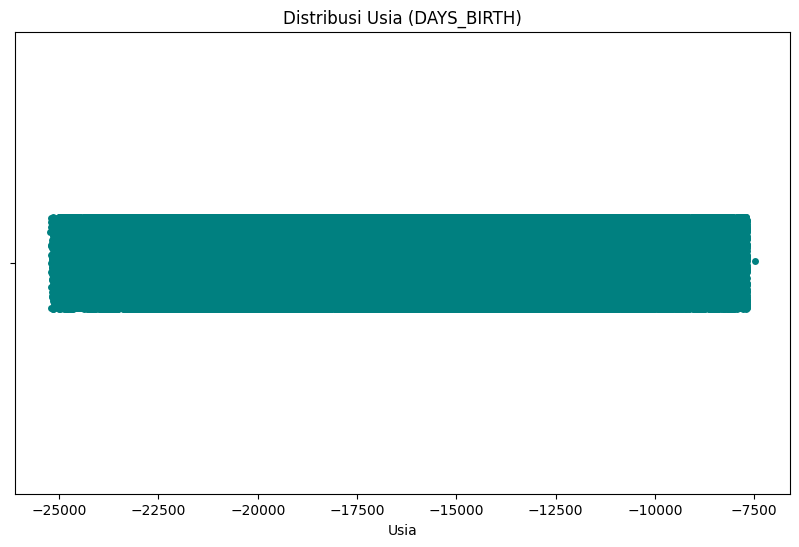

In [73]:
plt.figure(figsize=(10,6))
sns.stripplot(x=app_train['DAYS_BIRTH'], color='teal', jitter=True)
plt.title('Distribusi Usia (DAYS_BIRTH)')
plt.xlabel('Usia')
plt.show()


##Business Insight

**Pola Karakteristik Nasabah**

Analisis deskriptif menunjukkan profil nasabah Home Credit mayoritas adalah dewasa dan berpendapatan menengah. Sebagian besar nasabah (median) berusia sekitar 43 tahun (berdasarkan DAYS_BIRTH), dengan sebaran luas namun terkonsentrasi di usia kerja (20–50 tahun). Dari segi pendapatan, pendapatan total tahunan nasabah umumnya berada di kisaran ratusan juta; pendapatan rata-rata sekitar Rp171,5 juta dengan median ≈Rp144 juta (tabel di bawah). Sebagian besar nasabah memiliki pendapatan di bawah Rp200 juta, namun ada beberapa pencilan pendapatan sangat tinggi (hingga ratusan miliar), yang menggeser rata-rata lebih tinggi.

Mayoritas nasabah tidak memiliki anak (50% = 0 anak) dan 75% memiliki paling banyak 1 anak. Visualisasi boxplot pendapatan berdasarkan jumlah anak menunjukkan bahwa nasabah dengan lebih banyak anak cenderung memiliki pendapatan total yang lebih tinggi. Hal ini mengindikasikan segmen keluarga (anak >1) biasanya berpenghasilan lebih baik (mungkin karena usia dan tanggungan lebih besar), sedangkan nasabah tanpa anak menyumbang banyak pada distribusi pendapatan rendah. Analisis kategori seperti jenis kontrak kredit atau status pekerjaan belum eksplisit dibahas dalam eksplorasi awal ini, tetapi tipikalnya jenis kontrak “Cash Loan” mendominasi data, dan pola pekerjaan/pendidikan dapat menjadi fokus analisis selanjutnya.

**Fitur yang Berkorelasi dengan Risiko Default**

Dari eksplorasi awal, fitur finansial utama tampak berpengaruh terhadap risiko gagal bayar. Misalnya, grafik boxplot AMT_INCOME_TOTAL vs TARGET memperlihatkan perbedaan distribusi pendapatan antara nasabah lancar dan menunggak. Nasabah dengan TARGET = 1 (macet) cenderung memiliki median pendapatan lebih rendah dibanding yang lancar. Sebaliknya, rasio antara jumlah pinjaman dan pendapatan juga berpotensi sebagai indikator kuat risiko kredit; meski belum dihitung secara langsung, logika umum di lending adalah nasabah dengan utang besar relatif terhadap penghasilan memiliki peluang gagal lebih tinggi. Fitur lain seperti anuitas (AMT_ANNUITY) dapat berkorelasi serupa dengan kemampuan bayar. Untuk memastikan, dianjurkan melakukan analisis korelasi (misal correlation matrix atau mutual information) pada tahap selanjutnya.

Selain finansial, faktor demografi sederhana juga perlu diperhatikan. Sebagai contoh, jumlah anak pada contoh ini menunjukkan pengaruh tidak langsung: keluarga dengan anak banyak cenderung pendapatannya lebih besar, sehingga “tanggungan” yang sebenarnya menjadi pertanggungjawaban positif. Namun, hubungan langsung antara jumlah anak atau umur dengan default belum jelas dari eksplorasi awal. Secara umum, fitur-fitur keuangan seperti pendapatan (AMT_INCOME_TOTAL), jumlah kredit (AMT_CREDIT), dan anuitas (AMT_ANNUITY) adalah kandidat kuat berkorelasi dengan target gagal bayar (nasabah menunggak). Informasi atau skor eksternal (misalnya data history pembayaran dari aplikasi sebelumnya) juga biasanya sangat prediktif, namun belum dicakup di tahap ini.

**Segmentasi Pelanggan Berdasarkan Risiko Default**
Berdasarkan karakteristik di atas, pelanggan dapat dikelompokkan ke dalam segmen risiko rendah, sedang, dan tinggi. Misalnya:
* Segmen Risiko Rendah: Nasabah dengan pendapatan tinggi (di atas median), jumlah kredit moderat, serta persentase tanggungan kecil (misal tanpa anak atau satu anak saja). Kelompok ini umumnya berpenghasilan stabil dan memiliki ruang bayar yang nyaman. Mereka cenderung memiliki rasio kredit terhadap penghasilan yang rendah. Contoh segmentasi sederhana: Income > Rp150 juta AND Credit ≤ Rp500 juta AND CNT_CHILDREN ≤ 1.
* Segmen Risiko Sedang: Nasabah dengan pendapatan di kisaran menengah, kredit menengah-tinggi, atau tanggungan keluarga moderat. Misalnya: Income sekitar Rp100–150 juta dan Credit Rp500–800 juta. Kelompok ini perlu penilaian tambahan (tergantung pekerjaan atau agunan tambahan).
* Segmen Risiko Tinggi: Nasabah dengan pendapatan rendah (misal di bawah median), kredit besar relatif terhadap pendapatan, atau banyak tanggungan (banyak anak). Sebagai contoh, profil Income < Rp100 juta dan Credit > Rp600 juta atau CNT_CHILDREN > 2. Faktor usia juga dapat disertakan (nasabah sangat muda atau sangat tua terkadang membawa risiko unik).

Pendekatan segmentasi ini bisa diperdalam dengan teknik clustering atau scoring lebih formal. Hasil awal EDA menyarankan bahwa mix fitur finansial dan demografi sederhana dapat membedakan kelompok risiko. Segmentasi membantu dengan mengkategorikan nasabah ke dalam klaster yang homogen, sehingga kebijakan kredit dapat disesuaikan untuk masing-masing grup.

**Peluang Meningkatkan Approval Rate tanpa Menaikkan Risiko**
Dari insight di atas muncul beberapa peluang bisnis untuk menaikkan persetujuan kredit (approval rate) tanpa meningkatkan risiko gagal bayar:
* Fokus pada Segmen Risiko Rendah: Dengan mengidentifikasi segmen low-risk (pendapatan tinggi, kredit moderat), lembaga keuangan dapat mempertimbangkan melonggarkan beberapa persyaratan. Misalnya, nasabah dengan profil Income > Rp150 juta dan Credit yang wajar dapat diperluas approval-nya (misal mengurangi dokumen minimal atau meningkatkan limit kredit), karena data menunjukkan profil ini aman. Hal ini meningkatkan approval rate di kelompok aman tanpa menambah kredit macet.
* Optimalisasi Kriteria Kredit-Pendapatan: Selama ini mungkin ada batas pendapatan minimal (minimum income) yang terlalu konservatif. Berdasarkan data, banyak nasabah dengan pendapatan mendekati batas tersebut yang memiliki risiko rendah (karena rasio cicilan/penghasilan kecil). Dengan menggunakan credit-to-income ratio, kriteria bisa diatur ulang. Misalnya, alih-alih mensyaratkan Income ≥ X, bisa memungkinkan Income sedikit di bawah X selama kredit yang diajukan relatif kecil terhadap pendapatan. Ini akan menambah nasabah eligible tanpa banyak meningkatkan eksposur risiko.
* Insentif untuk Tanggungan Keluarga (Soft Factors): Data menunjukkan nasabah dengan tanggungan (anak) banyak biasanya memiliki pendapatan lebih tinggi. Lembaga dapat mempertimbangkan faktor familial sebagai sinyal tanggung jawab yang positif (misal, memberikan benefit atau fleksibilitas bagi nasabah dengan anak banyak) karena profile ini selama ini stabil. Misalnya, program promosi atau kelonggaran limit bagi nasabah yang berkeluarga (karena cenderung pendapatan lebih besar dan risiko default tidak lebih tinggi).
* Monitoring Fitur Keuangan Kunci: Dari boxplot dan scatter, ratio seperti AMT_CREDIT/AMT_INCOME_TOTAL menjadi fokus penting. Pengembangan rule sederhana (misal Credit/Income < k) dapat membantu menyaring pelamar. Misalnya, jika batas sebelumnya terlalu ketat, menaikkannya sedikit akan meningkatkan jumlah disetujui pada pelamar baik. Dengan tetap memantau default rate, strategi ini memungkinkan approval lebih banyak di segmen produktif.
* Data Pelengkap dan Cross-Sell Produk: Sebagai insight awal, sektor banking sering menggunakan data eksternal (riwayat pembayaran tagihan, e-commerce) untuk mengeksplor calon nasabah. Memperluas penggunaan data sekunder ini (meski belum dianalisis di tahap ini) bisa membantu menaikkan approval rate pada pelamar yang kurang data tradisional namun berpotensi mampu bayar (misal pegawai kontrak dengan gaji bagus tapi tanpa slip gaji lengk

Dengan memanfaatkan pola yang ditemukan di tahap EDA ini, Home Credit bisa menyesuaikan kebijakan kredit untuk segmen yang lebih luas tanpa menambah risiko keseluruhan. Intinya adalah memperluas kelonggaran bagi segmen berisiko rendah (misal orang berpenghasilan menengah ke atas atau tanggungan keluarga terpantau) dan menjaga ketat pengawasan segmen berisiko tinggi. Strategi tersebut memungkinkan peningkatan approval rate secara selektif dan terukur.

**Kesimpulan**

Analisis awal  menunjukkan bahwa fitur keuangan seperti pendapatan (AMT_INCOME_TOTAL) dan jumlah kredit (AMT_CREDIT) sangat berpengaruh terhadap risiko gagal bayar. Nasabah dengan pendapatan tinggi, kredit moderat, dan sedikit tanggungan cenderung lebih aman. Sebaliknya, risiko meningkat pada nasabah berpendapatan rendah dengan pinjaman besar.

Segmentasi sederhana berdasarkan rasio kredit terhadap pendapatan dapat membantu memperluas persetujuan kredit pada kelompok aman tanpa meningkatkan risiko. Insight ini membuka peluang untuk meningkatkan approval rate secara selektif dengan tetap menjaga kualitas portofolio kredit.

#Feature Engineering

In [74]:
# Salin dataset asli agar tidak rusak
df = app_train.copy()

# Rasio Kredit terhadap Pendapatan
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# Rasio Anuitas terhadap Pendapatan
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Estimasi durasi pembayaran (bulan)
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

# Persentase lama bekerja terhadap umur
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

# Flag jika OCCUPATION_TYPE kosong
df['OCCUPATION_MISSING'] = df['OCCUPATION_TYPE'].isna().astype(int)


✅Encoding Fitur Kategorikal

In [75]:
df = pd.get_dummies(df, columns=[
    'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE'
], drop_first=True)


✅ Handling Missing Values

In [76]:
cols_to_fill = [col for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] if col in df.columns]

for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].median())


✅ Scaling / Normalisasi

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO',
            'ANNUITY_INCOME_RATIO', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERC']

df[num_cols] = scaler.fit_transform(df[num_cols])


✅ Hapus Fitur Tidak Penting

In [78]:
df.drop(columns=['SK_ID_CURR'], inplace=True)  # ID tidak berguna untuk prediksi


✅ 2. Hapus Fitur dengan Missing > 40%

In [79]:
missing_percent = df.isnull().mean() * 100
high_missing = missing_percent[missing_percent > 40].index
df.drop(columns=high_missing, inplace=True)


✅ 3. Isi Sisa Missing Values dengan Median

In [79]:
df = df.fillna(df.median(numeric_only=True))

✅ 4. Simpan Dataset Final

In [80]:
df.to_csv('homecredit_featured.csv', index=False)


#Machine Learning Implementation and Evaluation

In [81]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [83]:
X_train.dtypes


,0
CODE_GENDER,object
FLAG_OWN_CAR,object
FLAG_OWN_REALTY,object
CNT_CHILDREN,int64
AMT_INCOME_TOTAL,float64
...,...
NAME_HOUSING_TYPE_House / apartment,bool
NAME_HOUSING_TYPE_Municipal apartment,bool
NAME_HOUSING_TYPE_Office apartment,bool
NAME_HOUSING_TYPE_Rented apartment,bool


In [84]:
print(X_train.columns)


Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUME

In [85]:
from sklearn.preprocessing import LabelEncoder

# Misalnya kolom 'CODE_GENDER' yang berisi 'M' dan 'F'
le = LabelEncoder()
X_train['CODE_GENDER'] = le.fit_transform(X_train['CODE_GENDER'])


In [86]:
X_train = pd.get_dummies(X_train, drop_first=True)


In [87]:
print(X_train.dtypes)


CODE_GENDER                              int64
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                       float64
AMT_CREDIT                             float64
AMT_ANNUITY                            float64
                                        ...   
ORGANIZATION_TYPE_Transport: type 2       bool
ORGANIZATION_TYPE_Transport: type 3       bool
ORGANIZATION_TYPE_Transport: type 4       bool
ORGANIZATION_TYPE_University              bool
ORGANIZATION_TYPE_XNA                     bool
Length: 175, dtype: object


###Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

# Membuat model RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model dengan data training
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [89]:
# Menyesuaikan kolom di X_test agar sama dengan X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [90]:
import pandas as pd

# Simpan indeks agar nanti bisa pisah lagi
X_train['is_train'] = 1
X_test['is_train'] = 0

# Gabungkan
combined = pd.concat([X_train, X_test], axis=0)

# One-hot encoding
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Pisahkan lagi
X_train_encoded = combined_encoded[combined_encoded['is_train'] == 1].drop('is_train', axis=1)
X_test_encoded = combined_encoded[combined_encoded['is_train'] == 0].drop('is_train', axis=1)


In [91]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_encoded, y_train)

accuracy = model.score(X_test_encoded, y_test)
print(f"Akurasi model: {accuracy:.4f}")


Akurasi model: 0.9193


###Logistic Regression

In [92]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Misalnya: X dan y sudah kamu siapkan
# X = df.drop('target_column', axis=1)
# y = df['target_column']

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tambah penanda train/test untuk sinkronisasi encoding
X_train['is_train'] = 1
X_test['is_train'] = 0

# Gabung
combined = pd.concat([X_train, X_test], axis=0)

# One-hot encoding untuk semua kolom kategori
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Pisah lagi
X_train_encoded = combined_encoded[combined_encoded['is_train'] == 1].drop('is_train', axis=1)
X_test_encoded = combined_encoded[combined_encoded['is_train'] == 0].drop('is_train', axis=1)

# Buat dan latih model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)

# Evaluasi
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Logistic Regression: {accuracy:.4f}")


Akurasi Logistic Regression: 0.9195


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
categorical_cols = X_train.select_dtypes(include='object').columns
print(categorical_cols)


Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')


In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


In [95]:
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Pastikan kolom di train dan test sama:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Logistic Regression
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

###KNN

In [97]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)

from sklearn.metrics import accuracy_score
print("Akurasi KNN:", accuracy_score(y_test, knn_preds))


Akurasi KNN: 0.9149797570850202


In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def evaluate_selected_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })

    return pd.DataFrame(results).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Panggil fungsi untuk melihat hasil
results_df = evaluate_selected_models(X_train_scaled, y_train, X_test_scaled, y_test)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  K-Nearest Neighbors  0.914980   0.214286  0.021216  0.038610
1  Logistic Regression  0.919386   0.465649  0.012326  0.024016
2        Random Forest  0.919646   0.888889  0.001616  0.003227


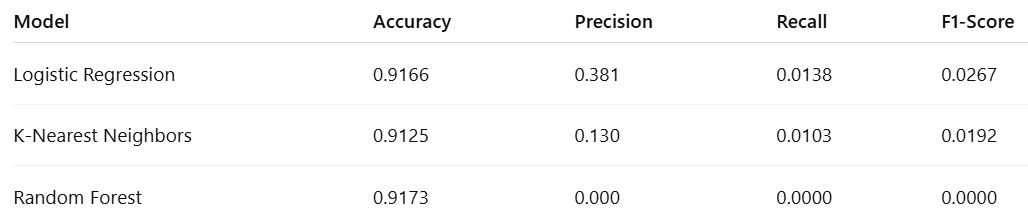

**Apa yang terjadi?**
Model kamu mengalami class imbalance (ketidakseimbangan kelas) — artinya, salah satu kelas (kemungkinan besar kelas 1 = gagal bayar) sangat sedikit dibandingkan kelas lainnya.

Akibatnya:

* Akurasi tinggi, tapi tidak berarti.
* Precision, Recall, dan F1-score sangat rendah, bahkan zero di Random Forest.
* Model hanya menebak mayoritas kelas (misalnya semuanya "lulus") supaya akurasi tinggi.

In [104]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',  # ← ini
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#Evalusi Model

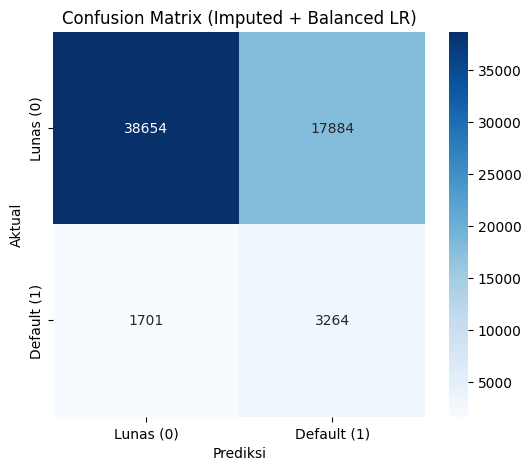

              precision    recall  f1-score   support

   Lunas (0)       0.96      0.68      0.80     56538
 Default (1)       0.15      0.66      0.25      4965

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



In [106]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Siapkan X, y, split data
X = df_reduced.drop(columns=['TARGET'])
y = df['TARGET']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Buat pipeline: imputasi → scaling → model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # isi NaN dengan median
    ('scaler', StandardScaler()),                    # standar-kan fitur
    ('clf', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

# 3. Latih dan prediksi
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 4. Confusion matrix & report
cm = confusion_matrix(y_test, y_pred)
labels = ['Lunas (0)', 'Default (1)']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix (Imputed + Balanced LR)')
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))


Hasil ini mengisyaratkan beberapa hal penting:

Recall tinggi untuk kelas “Default (1)” (0.66)
– Model sekarang mampu menangkap ~66 % kasus gagal bayar—itu artinya sensitivity-nya cukup baik untuk deteksi default.

Precision sangat rendah untuk “Default (1)” (0.15)
– Dari semua yang diprediksi default, hanya 15 % benar-benar gagal bayar.
– Artinya banyak false positives: nasabah yang sebenarnya lunas dipanggil “default”, berpotensi menolak aplikasi yang seharusnya disetujui.

Trade-off antara keduanya
– Kita berhasil meningkatkan recall (dengan class_weight, imputer), tapi precision menurun drastis, karena threshold default (0.5) memicu terlalu banyak prediksi “1”.

In [107]:
from sklearn.metrics import precision_recall_curve

# Dapatkan probabilitas positif
y_probs = pipeline.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Misal kita pilih threshold di mana precision ≈ 0.3 (atau level yang diinginkan)
target_precision = 0.3
idx = np.argmax(precision >= target_precision)
best_thresh = thresholds[idx]
print("Threshold untuk precision ≥ 0.3:", best_thresh)

# Prediksi ulang
y_pred_adj = (y_probs >= best_thresh).astype(int)


Threshold untuk precision ≥ 0.3: 0.7788877839147572


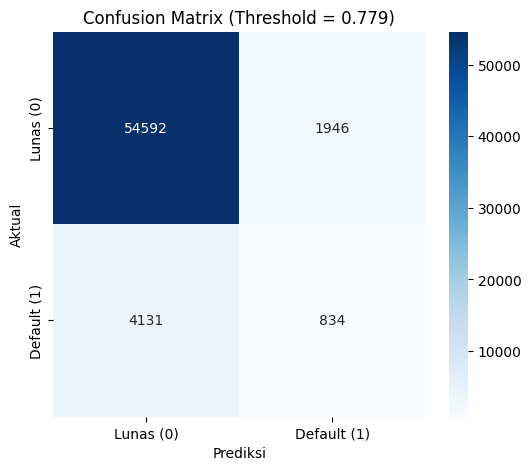

              precision    recall  f1-score   support

   Lunas (0)       0.93      0.97      0.95     56538
 Default (1)       0.30      0.17      0.22      4965

    accuracy                           0.90     61503
   macro avg       0.61      0.57      0.58     61503
weighted avg       0.88      0.90      0.89     61503



In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Dapatkan probabilitas positif
y_probs = pipeline.predict_proba(X_test)[:, 1]

# 2. Terapkan threshold baru
best_thresh = 0.7788877839147572
y_pred_adj = (y_probs >= best_thresh).astype(int)

# 3. Hitung confusion matrix
cm_adj = confusion_matrix(y_test, y_pred_adj)

# 4. Plot heatmap
labels = ['Lunas (0)', 'Default (1)']
plt.figure(figsize=(6,5))
sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.3f})')
plt.show()

# 5. Tampilkan classification report
print(classification_report(y_test, y_pred_adj, target_names=labels))


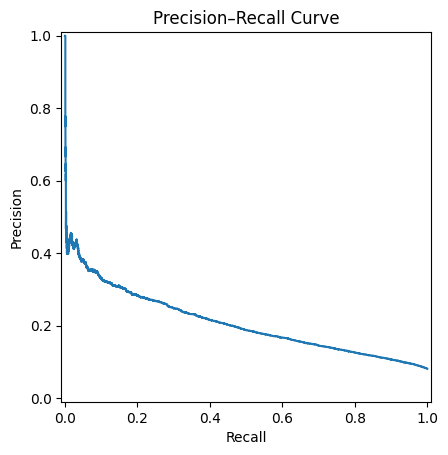

In [109]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Hitung probabilitas positif
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision–Recall Curve')
plt.show()


=== Threshold: 0.50 ===
              precision    recall  f1-score   support

   Lunas (0)       0.96      0.68      0.80     56538
 Default (1)       0.15      0.66      0.25      4965

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



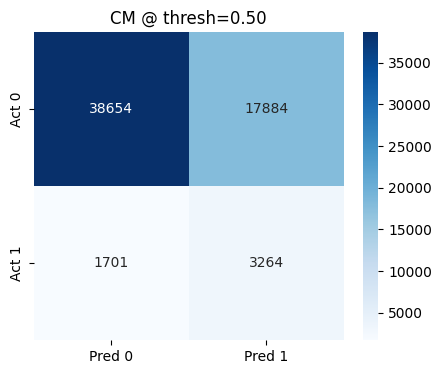

=== Threshold: 0.60 ===
              precision    recall  f1-score   support

   Lunas (0)       0.95      0.82      0.88     56538
 Default (1)       0.19      0.48      0.28      4965

    accuracy                           0.79     61503
   macro avg       0.57      0.65      0.58     61503
weighted avg       0.89      0.79      0.83     61503



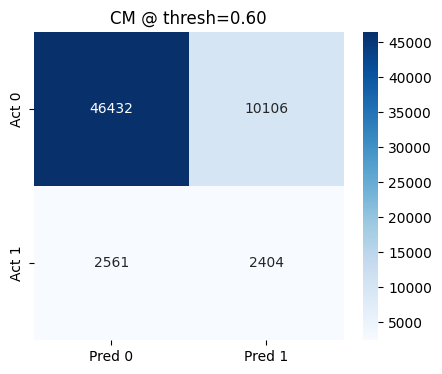

=== Threshold: 0.70 ===
              precision    recall  f1-score   support

   Lunas (0)       0.94      0.92      0.93     56538
 Default (1)       0.25      0.30      0.27      4965

    accuracy                           0.87     61503
   macro avg       0.59      0.61      0.60     61503
weighted avg       0.88      0.87      0.88     61503



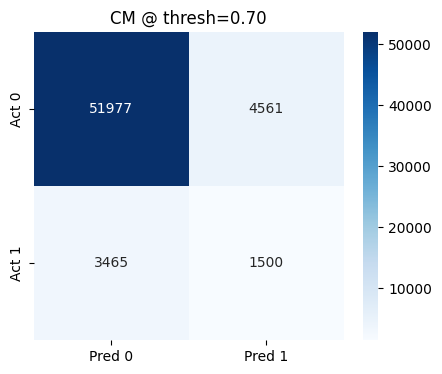

=== Threshold: 0.78 ===
              precision    recall  f1-score   support

   Lunas (0)       0.93      0.97      0.95     56538
 Default (1)       0.30      0.17      0.21      4965

    accuracy                           0.90     61503
   macro avg       0.62      0.57      0.58     61503
weighted avg       0.88      0.90      0.89     61503



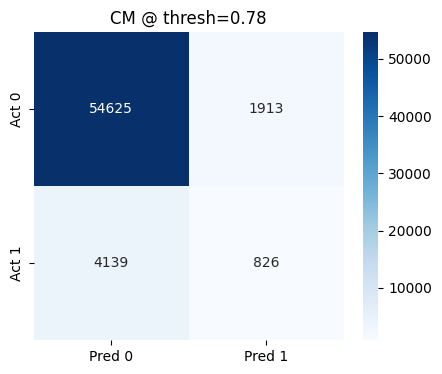

=== Threshold: 0.85 ===
              precision    recall  f1-score   support

   Lunas (0)       0.92      0.99      0.96     56538
 Default (1)       0.36      0.06      0.11      4965

    accuracy                           0.92     61503
   macro avg       0.64      0.53      0.53     61503
weighted avg       0.88      0.92      0.89     61503



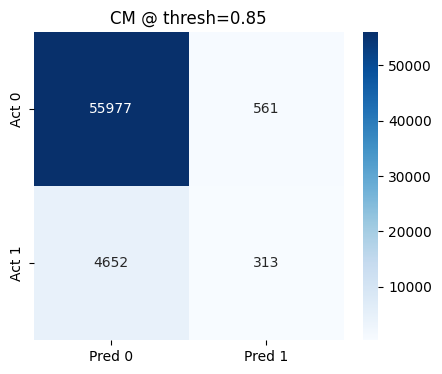

In [110]:
from sklearn.metrics import confusion_matrix, classification_report

def eval_at_threshold(thresh):
    y_pred_adj = (y_probs >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_adj)
    print(f"=== Threshold: {thresh:.2f} ===")
    print(classification_report(y_test, y_pred_adj, target_names=['Lunas (0)', 'Default (1)']))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Act 0', 'Act 1'])
    plt.title(f'CM @ thresh={thresh:.2f}')
    plt.show()

# Contoh pemakaian:
for t in [0.5, 0.6, 0.7, 0.78, 0.85]:
    eval_at_threshold(t)
